<a href="https://colab.research.google.com/github/alepenaa94/TP1_Real_or_Not/blob/master/TP1_Real_or_Not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRABAJO PRÁCTICO 1: Análisis Exploratorio de Datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 10)
sns.set(style="darkgrid")
%matplotlib inline

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
train_df = pd.read_csv('./Data/train.csv', encoding='latin-1',dtype={'id': np.uint16,'target': np.bool})

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,True
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True


## Tratamiento de datos

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   uint16
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   bool  
dtypes: bool(1), object(3), uint16(1)
memory usage: 200.9+ KB


Podemos observar que las columnas **"keyword"** y **"location"** poseen algunos valores nulos, vamos a analizar cada caso particular para determinar como vamos a proceder con los análisis.

In [5]:
train_df['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

El campo **keyword** tiene **61 registros** con valores nulos. Como es una cantidad pequeña en relación a la cantidad total de registros (**7613 registros**), para los análisis vamos a considerar descartar los registros nulos.

In [6]:
#train_df['keyword'].fillna(value='',inplace=True)

Veamos que tipo de valores tiene este campo.

In [7]:
train_df['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
damage                   41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [8]:
train_df.loc[~train_df['keyword'].isnull() & train_df['keyword'].str.contains('%20')]['keyword'].value_counts()

body%20bags              41
oil%20spill              38
burning%20buildings      37
dust%20storm             36
nuclear%20reactor        36
cliff%20fall             36
bridge%20collapse        35
structural%20failure     35
suicide%20bomb           35
emergency%20plan         35
buildings%20burning      35
airplane%20accident      35
natural%20disaster       34
heat%20wave              34
nuclear%20disaster       34
loud%20bang              34
buildings%20on%20fire    33
blew%20up                33
chemical%20emergency     33
emergency%20services     33
body%20bag               33
body%20bagging           33
suicide%20bombing        33
mass%20murder            33
blown%20up               33
fire%20truck             33
violent%20storm          33
mass%20murderer          32
forest%20fires           32
suicide%20bomber         31
wild%20fires             31
first%20responders       29
bush%20fires             25
war%20zone               24
forest%20fire            19
radiation%20emergenc

Observamos que en algunos keyword aparece "%20" en donde va un espacio; vamos a limpiar esto para mayor claridad en la información.

In [9]:
train_df['keyword'] = train_df['keyword'].str.replace('%20',' ')

Posiblemente luego analicemos los textos y veamos la posibilidad de completar estos keyword nulos con algun valor mas significativo.

## Analizando location

In [10]:
train_df['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [11]:
train_df['location'].sample(30)

5305                   The Netherlands
7602                               NaN
669                           Karachi 
2394     Road to the Billionaires Club
3125                               NaN
3627                         TechFish 
7499                              709?
5676                           watford
5809                 Cassadaga Florida
4497             NAWF SIDE POKING OUT 
1765                               NaN
7044                    Washington, DC
4850                               USA
3037                   California, USA
2968                  New Jersey/ D.R.
6902             Stage with Trey Songz
1819                Va Beach, Virginia
3112                    North Carolina
5885                               USA
1092                    Des Moines, IA
2918    Inside your webcam. Stop that.
2021    Bhopal, Madhya Pradesh, India.
2233                               NaN
6955                               NaN
2584                               NaN
6705                     

Por ahora dejamos en blanco estos datos, se observa que la ubicacion ingresada no es siempre algo coherente.

Hay que ver que hacer con los registros que tienen location = NaN

In [12]:
# analizo las ubicaciones
locations = train_df['location']
locations_count = locations.value_counts()
locations_count

USA                           104
New York                       71
United States                  50
London                         45
Canada                         29
                             ... 
Jaipur, Rajasthan, India        1
Im Around ... Jersey            1
Pawnee                          1
Birmingham, United Kingdom      1
Suburban Detroit, Michigan      1
Name: location, Length: 3341, dtype: int64

Text(0, 0.5, 'Cantidad de Tweets')

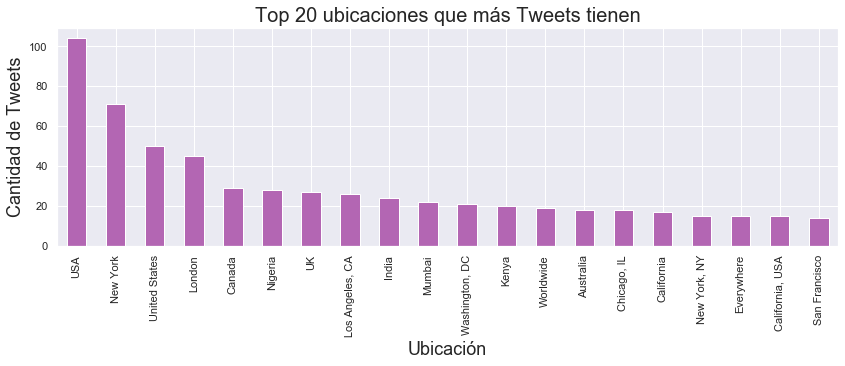

In [13]:
#Top 20 ubicaciones que más Tweets tienen
plot = train_df['location'].value_counts()[0:20].plot(kind='bar',figsize=(14,4), color=(0.7,0.4,0.7))
plot.set_title('Top 20 ubicaciones que más Tweets tienen', fontsize=20);
plot.set_xlabel('Ubicación', fontsize=18)
plot.set_ylabel('Cantidad de Tweets', fontsize=18)

In [14]:
# Quiero ver las ubicaciones que aparecen sólo 1 vez
location_with_one_tweet = locations_count[locations_count == 1]
location_with_one_tweet.sample(15)

Vero Beach , FL            1
illinois. united state     1
Dallas, Texas.             1
???? ???????               1
Lurking                    1
Lindenhurst                1
Spain but Opa-Locka, FL    1
BOT ACCOUNT                1
Asia Pacific               1
Maryland, USA              1
Wilmington, Delaware       1
Enterprise, NV             1
Miami ??                   1
NY || live easy?           1
Lubbock, Texas             1
Name: location, dtype: int64

In [15]:
location_with_one_tweet.count()

2818

In [16]:
# Ubicaciones diferentes
len(locations.unique())

3342

In [17]:
# Porcentaje de ubicaciones que solo aparecen 1 vez
prom_one = location_with_one_tweet.count()/len(locations.unique())*100
prom_one

84.32076600837821

2818 ubicaciones sólo aparecen una vez. Aproximadamente el 84,3% de las ubicaciones tienen un sólo tweet. ¿Cuántas de esas corresponden a tweets falsos?

In [18]:
# Agrupo y filtro para quedarme con los q tienen 1 tweet
tweets_one_location = train_df.groupby("location").filter(lambda x: len(x) == 1)
tweets_one_location.head()

,id,keyword,location,text,target
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,False
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,True
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,True
39,57,ablaze,Paranaque City,Ablaze for you Lord :D,False
42,62,ablaze,milky way,Had an awesome time visiting the CFC head offi...,False


In [19]:
# De los tweets con ubicaciones que sólo aparecen una vez, 
#¿Cuántos corresponden a tweets verdaderos y cuántos a falsos?
tweets_one_location['target'].value_counts()

False    1716
True     1102
Name: target, dtype: int64

Aproximadamente, de esos tweets, el 60,9% terminan siendo falsos.

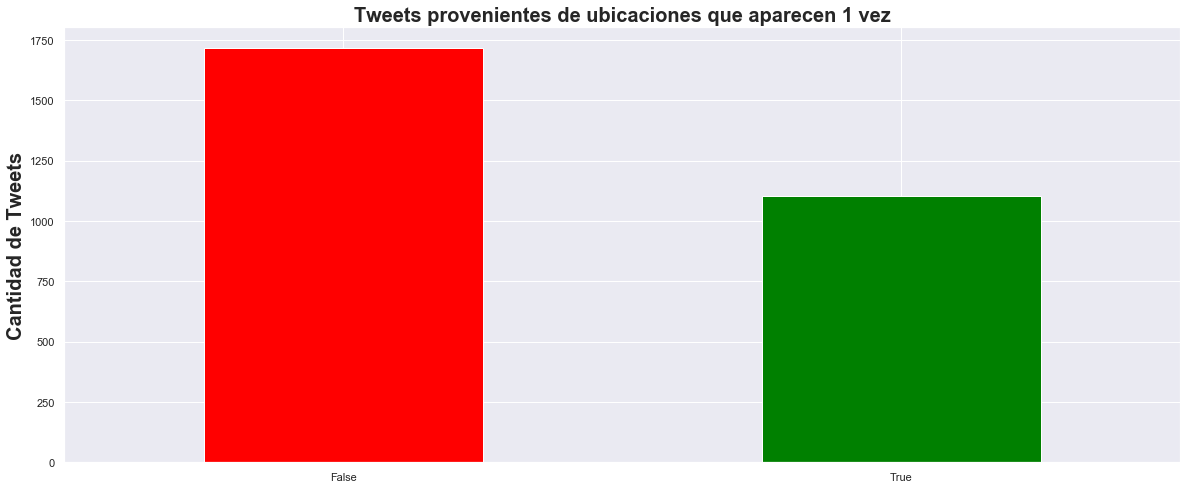

In [20]:
# Gráfico para ver cuántos de esos tweets son Falsos/ Verdaderos
tweets_one_location['target'].value_counts().plot.bar(figsize=(20,8), color=('red','green'));
plt.xticks(rotation=0)
plt.title('Tweets provenientes de ubicaciones que aparecen 1 vez', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=20,weight='bold');

In [21]:
train_df['target'].value_counts()

False    4342
True     3271
Name: target, dtype: int64

En relacion a todos los registros, representa el 39.5% de los tweets falsos, y casi 33.7% de los verdaderos.

## Primeros analisis

In [22]:
train_df['word_count'] = train_df['text'].str.count(' ') + 1
train_df['not_target'] = 0
train_df.loc[train_df['target']==0,'not_target'] = 1

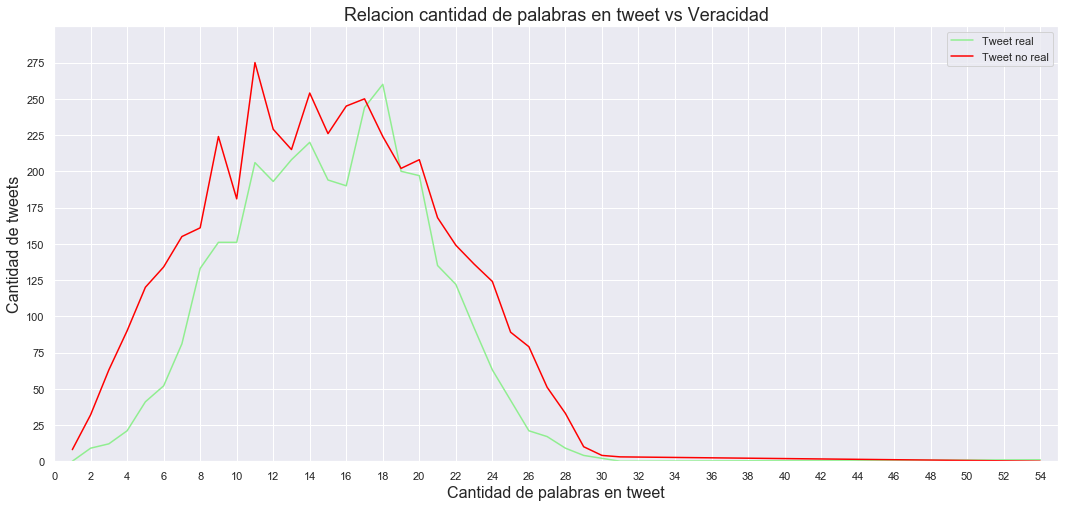

In [23]:
df = train_df.groupby('word_count').agg({'target':'sum','not_target':'sum'}).reset_index()

plt.figure(figsize=(18,8))
ax = sns.lineplot(x='word_count',y='target',data=df,color="lightgreen", label='Tweet real')
ax = sns.lineplot(x='word_count',y='not_target',data=df,color="red", label='Tweet no real')
ax.set_ylim(0,300)
ax.set_yticks(range(0,300,25))
ax.set_xlim(0,55)
ax.set_xticks(range(0,55,2))

ax.set_title('Relacion cantidad de palabras en tweet vs Veracidad', fontsize=18)
ax.set_xlabel('Cantidad de palabras en tweet',fontsize=16)
ax.set_ylabel('Cantidad de tweets', fontsize=16);

## Análisis de la longitud de los tweets

In [24]:
#Creamos una columna con la longitud del tweet.
train_df['longitud_del_tweet'] = train_df['text'].str.len()

In [25]:
#Analizamos las estadísticas de los tweets verdaderos.
train_df[train_df['target']]['longitud_del_tweet'].describe()

count    3271.000000
mean      108.444207
std        29.511567
min        14.000000
25%        88.000000
50%       115.000000
75%       136.000000
max       161.000000
Name: longitud_del_tweet, dtype: float64

In [26]:
#Analizamos las estadísticas de los tweets falsos.
train_df[~train_df['target']]['longitud_del_tweet'].describe()

count    4342.000000
mean       95.981345
std        36.100118
min         7.000000
25%        68.000000
50%       101.000000
75%       130.000000
max       163.000000
Name: longitud_del_tweet, dtype: float64

In [27]:
train_df = train_df.astype({'longitud_del_tweet':np.uint8})

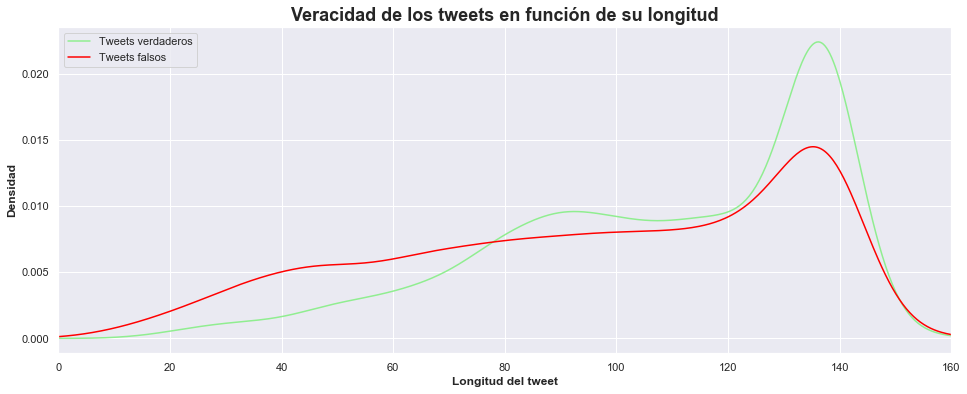

In [28]:
fig= plt.figure()
ax = fig.add_subplot(111)

plt.title('Veracidad de los tweets en función de su longitud',fontsize=18,fontweight='bold')

train_df[train_df['target']]['longitud_del_tweet'].plot.kde(color='lightgreen', figsize=(16, 6), label = 'Tweets verdaderos')
train_df[~train_df['target']]['longitud_del_tweet'].plot.kde(color='red', ax=ax, figsize=(16, 6), label = 'Tweets falsos')

ax.set_xlabel('Longitud del tweet', fontsize=12, fontweight='bold')
ax.set_ylabel('Densidad', fontsize=12, fontweight='bold')

ax.set_xlim(0, 160) #Seteamos los límites del eje x conociendo el valor máximo y mínimo de la longitud de los tweets.
ax.legend()

plt.show()

En está visualización podemos observar que los tweets que tienen una longitud menor a 80 caracteres son en su mayoría falsos, mientras que los que tienen una longitud superior tienden a ser verdaderos. Tambíen podemos ver que la longitud de los tweets tiene un pico llegando a los 140 caracteres, lo cuál tiene sentido considerando las limitaciones que la plataforma solía tener respecto a la longitud de los mismos.

## Análisis de los keywords

Como vimos previamente, la columna keywords tiene **61 registros** con valores nulos. Como es una cantidad pequeña en relación a la cantidad total de registros (**7613 registros**), para este análisis vamos a descartar los registros nulos.

In [29]:
keywords_verdaderos = train_df.loc[~train_df['keyword'].isnull() & train_df['target']]['keyword']
keywords_verdaderos.value_counts()

outbreak       39
wreckage       39
derailment     39
typhoon        37
debris         37
               ..
ruin            1
electrocute     1
body bags       1
body bag        1
blazing         1
Name: keyword, Length: 220, dtype: int64

In [30]:
keywords_falsos = train_df.loc[~train_df['keyword'].isnull() & ~train_df['target']]['keyword']
keywords_falsos.value_counts()

body bags          40
armageddon         37
harm               37
deluge             36
ruin               36
                   ..
suicide bomber      1
outbreak            1
suicide bombing     1
typhoon             1
oil spill           1
Name: keyword, Length: 218, dtype: int64

In [31]:
df1 = keywords_verdaderos.value_counts().to_frame().reset_index()
df1.columns = ['keyword','count']

df2 = keywords_falsos.value_counts().to_frame().reset_index()
df2.columns = ['keyword','count']

merge_keywords = pd.merge(df1,df2,how='outer',on='keyword')
merge_keywords.head()

,keyword,count_x,count_y
0,outbreak,39.0,1.0
1,wreckage,39.0,NaN
2,derailment,39.0,NaN
3,typhoon,37.0,1.0
4,debris,37.0,NaN


In [32]:
merge_keywords.fillna(value=0,inplace=True)

In [33]:
merge_keywords.rename(columns={'count_x':'cantidad_verdaderos','count_y':'cantidad_falsos'},inplace=True)

In [34]:
merge_keywords.head()

,keyword,cantidad_verdaderos,cantidad_falsos
0,outbreak,39.0,1.0
1,wreckage,39.0,0.0
2,derailment,39.0,0.0
3,typhoon,37.0,1.0
4,debris,37.0,0.0


In [35]:
merge_keywords['porcentaje_verdaderos'] = (merge_keywords['cantidad_verdaderos'] / (merge_keywords['cantidad_verdaderos'] + merge_keywords['cantidad_falsos'])) * 100

In [36]:
merge_keywords.set_index('keyword',inplace=True)

In [37]:
merge_keywords.head()

,cantidad_verdaderos,cantidad_falsos,porcentaje_verdaderos
keyword,,,
outbreak,39.0,1.0,97.500000
wreckage,39.0,0.0,100.000000
derailment,39.0,0.0,100.000000
typhoon,37.0,1.0,97.368421
debris,37.0,0.0,100.000000


Vamos a analizar los keyword en función del porcentaje de tweets verdaderos. Para ello, vamos a considerar como significativos los keywords que tengan por lo menos 30 tweets.

In [38]:
merge_keywords.loc[(merge_keywords['cantidad_verdaderos'] + merge_keywords['cantidad_falsos']) > 30].nlargest(10,'porcentaje_verdaderos')[['cantidad_verdaderos','cantidad_falsos']]

,cantidad_verdaderos,cantidad_falsos
keyword,,
wreckage,39.0,0.0
derailment,39.0,0.0
debris,37.0,0.0
outbreak,39.0,1.0
typhoon,37.0,1.0
oil spill,37.0,1.0
suicide bombing,32.0,1.0
suicide bomber,30.0,1.0
rescuers,32.0,3.0


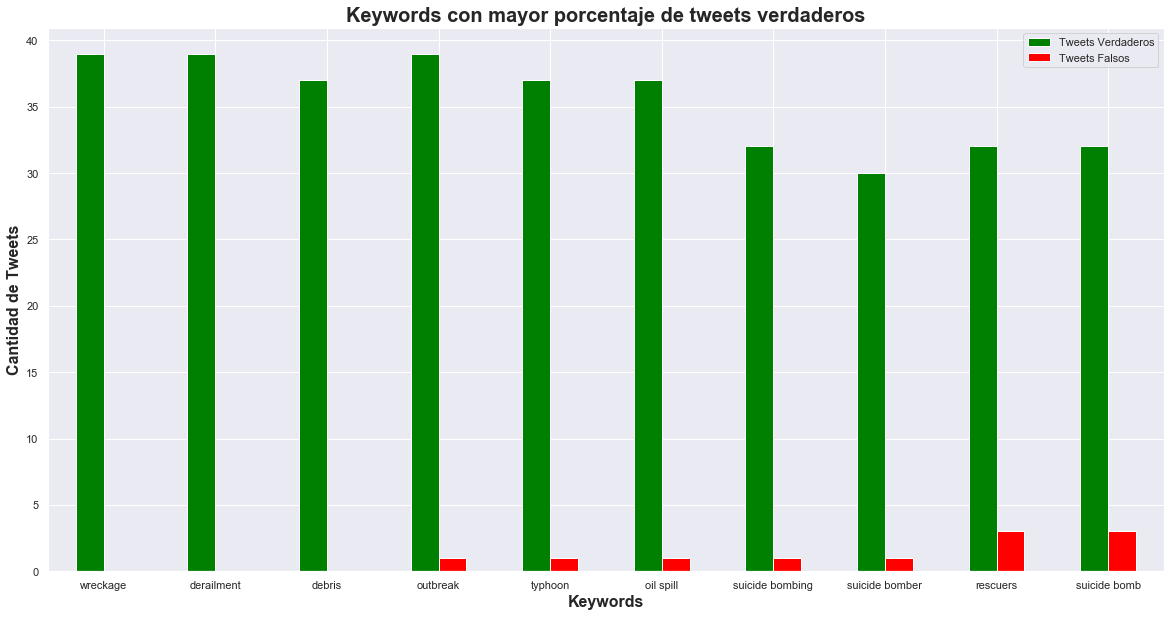

In [39]:
df_aux = merge_keywords.loc[(merge_keywords['cantidad_verdaderos'] + merge_keywords['cantidad_falsos']) > 30].nlargest(10,'porcentaje_verdaderos')[['cantidad_verdaderos','cantidad_falsos']]

df_aux.columns = ['Tweets Verdaderos','Tweets Falsos']

df_aux.plot.bar(figsize=(20,10),color=('green','red'));

plt.xticks(rotation=0)

plt.title('Keywords con mayor porcentaje de tweets verdaderos', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold')
plt.xlabel('Keywords', fontsize=16,weight='bold');

Hacer algun comentario...

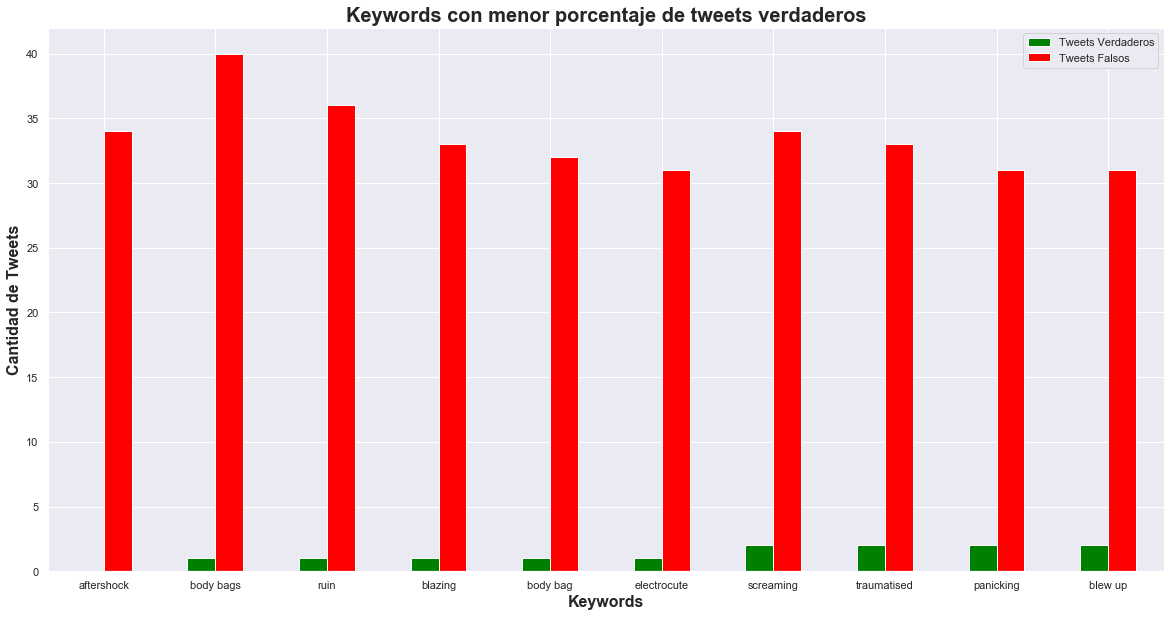

In [40]:
df_aux = merge_keywords.loc[(merge_keywords['cantidad_verdaderos'] + merge_keywords['cantidad_falsos']) > 30].nsmallest(10,'porcentaje_verdaderos')[['cantidad_verdaderos','cantidad_falsos']]

df_aux.columns = ['Tweets Verdaderos','Tweets Falsos']

df_aux.plot.bar(figsize=(20,10),color=('green','red'));

plt.xticks(rotation=0)

plt.title('Keywords con menor porcentaje de tweets verdaderos', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold')
plt.xlabel('Keywords', fontsize=16,weight='bold');

Hacer algun comentario...

## Análisis de menciones

Vamos a analizar la naturaleza de los tweets en base a si se realiza alguna mención en el mismo o no.

In [41]:
train_df['tiene_menciones'] = train_df['text'].str.contains('@')

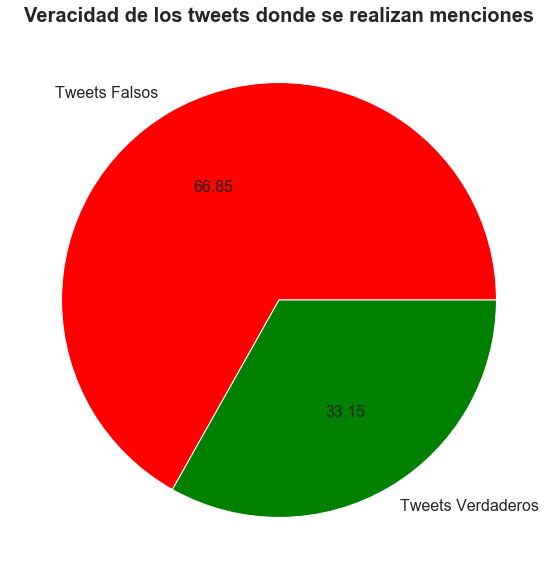

In [42]:
train_df.loc[train_df['tiene_menciones']]['target'].value_counts().plot.pie(labels=['Tweets Falsos',\
                                                        'Tweets Verdaderos'],\
                                                figsize=(10, 10),\
                                                autopct='%.2f', fontsize=16,colors=('red','green'))

plt.ylabel('');
plt.title('Veracidad de los tweets donde se realizan menciones',fontsize=20,weight='bold');

Podemos ver que en 2/3 de los tweets en donde se realiza alguna mención, el tweet resulta ser falso.

## Análisis de hashtags

Vemos si hay alguna relación entre la cantidad de hashtags del tweet y la veracidad del mismo.

In [43]:
train_df['cantidad_de_hashtags'] = train_df['text'].str.count('#')

In [44]:
train_df.groupby(['cantidad_de_hashtags','target']).agg({'id':'count'})

id
cantidad_de_hashtags target      
0                    False   3456
                     True    2396
1                    False    482
                     True     482
2                    False    202
                     True     203
3                    False    108
                     True     100
4                    False     45
                     True      38
5                    False     18
                     True      23
6                    False     19
                     True       7
7                    False      4
                     True       4
8                    False      1
                     True       7
9                    False      2
10                   False      3
                     True       7
11                   False      2
13                   True       4

No aporta nada, esta dividido bastante equitativamente; hay que ver si podemos hacer algo distinto con los hashtags.

## Análisis de "tweets expresivos"

Consideramos como "tweet expresivo" a los tweets en donde se utiliza múltiples signos de exclamación o interrogación consecutivos.

In [45]:
train_df['es_expresivo'] = (train_df['text'].str.contains('\!\!') | train_df['text'].str.contains('\?\?'))

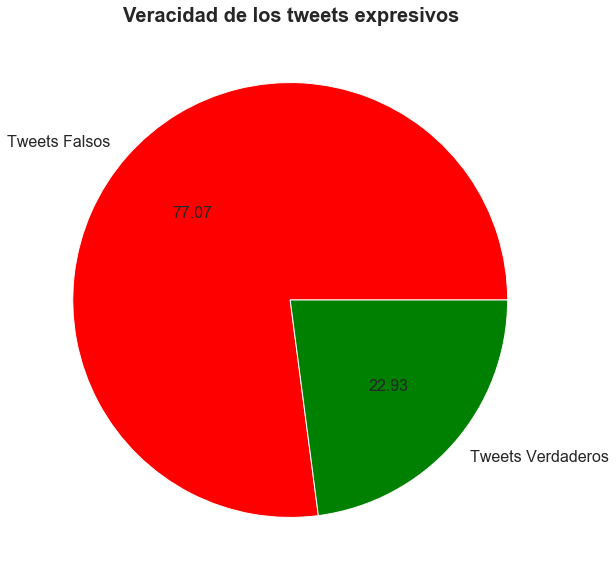

In [46]:
train_df.loc[train_df['es_expresivo']]['target'].value_counts().plot.pie(labels=['Tweets Falsos',\
                                                        'Tweets Verdaderos'],\
                                                figsize=(10, 10),\
                                                autopct='%.2f', fontsize=16,colors=('red','green'))

plt.ylabel('');
plt.title('Veracidad de los tweets expresivos',fontsize=20,weight='bold');

Como podría esperarse, los tweets en donde se utilizan signos de puntuación de manera exagerada, en general para resaltar una emoción del usuario, no suelen ser sobre noticias reales.

## Hay algún registro que el <i><b>text</b></i> NO contenga la <i><b>keyword</b></i>?

In [47]:
def f_aux(row):
  if str(row['keyword']).lower() in str(row['text']).lower():
    return True
  return False

train_df['contiene_key'] = train_df.loc[~train_df['keyword'].isnull()].apply(f_aux,axis=1)

In [48]:
train_df['contiene_key'].value_counts()

True     6700
False     852
Name: contiene_key, dtype: int64

In [49]:
train_df.loc[train_df['contiene_key']==False].head(10)[['keyword','text']]

,keyword,text
32,ablaze,We always try to bring the heavy. #metal #RT h...
40,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...
45,ablaze,I gained 3 followers in the last week. You? Kn...
48,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...
49,ablaze,First night with retainers in. It's quite weir...
52,ablaze,SANTA CRUZ ÂÃÃ Head of the St Elizabeth Pol...
54,ablaze,Noches El-Bestia '@Alexis_Sanchez: happy to se...
83,accident,#TruckCrash Overturns On #FortWorth Interstate...
103,aftershock,'The man who can drive himself further once th...
105,aftershock,'There is no victory at bargain basement price...


In [50]:
train_df.iloc[5540]['text']

'Radioactive Box Quarantined - IsraelÂ\x89Ã\x9bÂªs Ashdod Port was evacuated when emergency teams discovered radiation emittin... http://t.co/swQ5lMyDka'

In [51]:
train_df.iloc[103]['text']

"'The man who can drive himself further once the effort gets painful is the man who will win.' \nRoger Bannister"

In [52]:
train_df.iloc[83]['text']

"#TruckCrash Overturns On #FortWorth Interstate http://t.co/Rs22LJ4qFp Click here if you've been in a crash&gt;http://t.co/Ld0unIYw4k"

In [53]:
print(train_df.iloc[5540]['keyword'])
print(train_df.iloc[5540]['text'])

radiation emergency
Radioactive Box Quarantined - IsraelÂÃÂªs Ashdod Port was evacuated when emergency teams discovered radiation emittin... http://t.co/swQ5lMyDka


In [54]:
train_df.loc[train_df['contiene_key']==False]['target'].value_counts()

False    500
True     352
Name: target, dtype: int64

Podemos observar que de todos los datos que tienen keyword válido, solo <b>6700</b> 
son los que contienen exactamente la palabra. Los otros <b>852</b> son o interpretaciones del tweet y ruido. No se considera que vale la pena quitar 852 registros por la posibilidad de que la mayoria sean o no ruido.

## Más analisis de Longitud- Covarianza y Correlacion

In [55]:
train_df['longitud_del_tweet'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
longitud_del_tweet,7613.0,101.336136,33.991338,7.0,78.0,107.0,134.0,163.0


Estaría bueno analizar más en detalle que va sucediendo a medida que la longitud crece, que sucede con el target, es "mas real" o no el tweet?<br>
Creamos unas categorías segun lo visto anteriormente donde de todas las longitudes el 25% promedio esta en 78, el 50% en 107 y asi ... la idea de estas categorías es agrupar rangos entre 0 a 25 , 25 a 50 , 50 a 75 y 75 a 100 segun estas medidas obtenidas.

In [56]:
train_df.loc[train_df['longitud_del_tweet']<78.0,'Categ']="0 a 25"
train_df.loc[train_df['longitud_del_tweet']>=78.0,'Categ']="25 a 50"
train_df.loc[train_df['longitud_del_tweet']>=107.0,'Categ']= "50 a 75"
train_df.loc[train_df['longitud_del_tweet']>=134.0,'Categ']= "75 a 100"

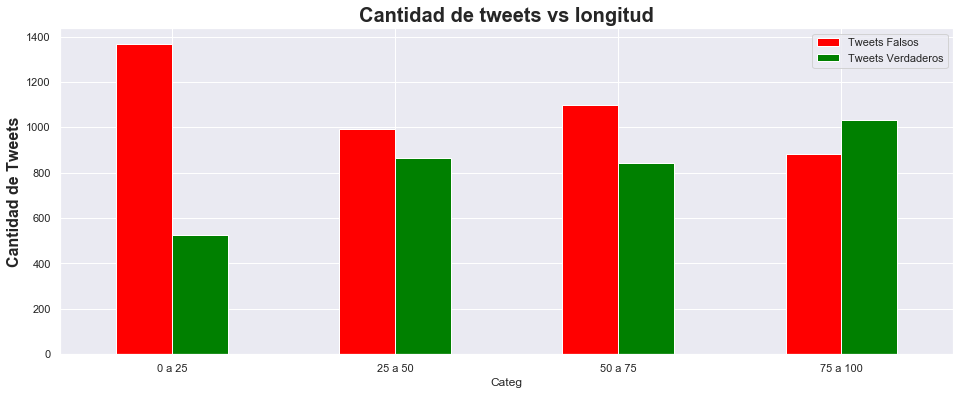

In [57]:
df_aux = train_df.groupby(['Categ','target'])['id'].count().unstack()
df_aux.columns = ['Tweets Falsos','Tweets Verdaderos']
df_aux.plot.bar(figsize=(16,6), color=('red','green'));
plt.xticks(rotation=0)
plt.title('Cantidad de tweets vs longitud', fontsize=20,weight='bold')
plt.ylabel('Cantidad de Tweets', fontsize=16,weight='bold');

Aca podemos ver que a una longitud menor es más probable que sea un tweet no real y que cuanto más largo sea el tweet mayor su probabilidad de ser real.
<br>
La idea ahora es analizar cual es la covarianza y correlacion entre estas categorias creadas en base a su longitud (como largo de la cadena) vs target.

In [58]:
df_aux = train_df
df_aux['Categ_A'] = np.where(df_aux['Categ']=="0 a 25",1,0)
df_aux['Categ_B'] = np.where(df_aux['Categ']=="25 a 50",1,0)
df_aux['Categ_C'] = np.where(df_aux['Categ']=="50 a 75",1,0)
df_aux['Categ_D'] = np.where(df_aux['Categ']=="75 a 100",1,0)

In [59]:
df_aux[['Categ_A','Categ_B','Categ_C','Categ_D','longitud_del_tweet','target']].corr()

,Categ_A,Categ_B,Categ_C,Categ_D,longitud_del_tweet,target
Categ_A,1.000000,-0.327100,-0.337233,-0.333972,-0.820184,-0.176486
Categ_B,-0.327100,1.000000,-0.332614,-0.329397,-0.154991,0.042091
Categ_C,-0.337233,-0.332614,1.000000,-0.339601,0.337340,0.005319
Categ_D,-0.333972,-0.329397,-0.339601,1.000000,0.631737,0.128873
longitud_del_tweet,-0.820184,-0.154991,0.337340,0.631737,1.000000,0.181513
target,-0.176486,0.042091,0.005319,0.128873,0.181513,1.000000


Podemos ver como aumenta la correlacion un poco a medida que la logitud aumenta, pero esto no nos indica si aumenta segun si es o no real

## Algun analisis entre los hashtags y el texto del tweet
Veamos si podemos armar algun array con los hashtag que tenga el tweet

In [61]:
import re
def split_hashtag(hashtag):
    return re.findall(r"#(\w+)",hashtag)

train_df['hashtags'] = train_df['text'].apply(split_hashtag)

In [62]:
train_df['cantidad_de_hashtags'].value_counts()

0     5852
1      964
2      405
3      208
4       83
5       41
6       26
10      10
7        8
8        8
13       4
11       2
9        2
Name: cantidad_de_hashtags, dtype: int64

In [63]:
df = train_df[['hashtags']].explode('hashtags').dropna()
top20_hashtags = df['hashtags'].value_counts().head(40).to_list()

top20_hashtags = [str(hashtag).lower() for hashtag in top20_hashtags]

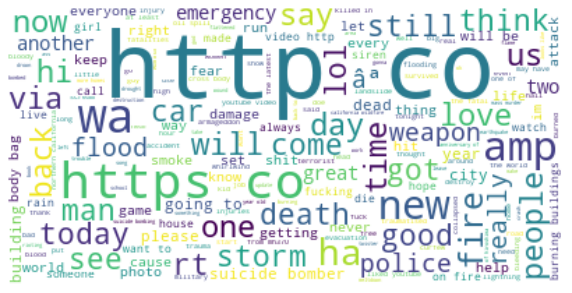

In [64]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = train_df['text'].str.split(' ').to_frame().explode('text')['text'].str.cat(sep=' ').lower()

stopwords = set(STOPWORDS)
stopwords.update(top20_hashtags)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Buscar una conclusion sobre los hashtags que mayormente se usan y cuales de estos se pueden categorizar como "criticos" para decir si es tweet real o no
<br>
<br>
Podemos ver algunas palabras de hashtag que podrian resultar impotantes como:
* FIRE
* POLICE
* WEAPON
* EMERGENCY
* HELP
* DEAD
* DAMAGE
* SMOKE
<br>
Podemos ver la posibilidad de caategorizar estos 